In [2]:
configFile = "config.toml"
include("src/ladderDGA_Julia.jl")

Reading Inputs...Reading Fortran Input, this can take several minutes.
Done Reading Gamma
Done Reading chi
loading from vars.jld
TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
(81, 82, 82)(81, 82, 82)(81,)(81, 82, 82)
Inputs Read. Starting Computation.
    Found usable intervals for local susceptibility of length 
          sp: 13
          ch: 11 
          χLoc_sp = 0.3836, χLoc_ch = 0.0203
Setting up and calculating k Grid: 
Calculating bubble: 
in bubble: (81,)
gnuomega indices: 122
in bubble: ModelParameters(2.0, 1.0, 15.0, 1.0, 3)
in bubble: SimulationParameters(41, 40, 0, 10, false, false, false, false, "FFT")
  2.983337 seconds (5.80 M allocations: 439.554 MiB, 4.43% gc time)
Calculating χ and γ: 
 57.872018 seconds (7.57 M allocations: 1.056 GiB, 0.37% gc time)
Found usable intervals for non-local susceptibility of length 
          sp: 35:47, length: 13
          ch: 36:46, length: 11
          usable: 36:46, length: 11
Using rhs for non tail corrected 

In [8]:
function construct_f2(λsp, λch, χsp, χch, qMultiplicity; rhs=0.5)
   χch_λ = χ_λ(χch, λch)
   χsp_λ = χ_λ(χsp, λsp)
   tmp =  sum(sum(χch_λ .+ χsp_λ, dims=1)[1,:] .* qMultiplicity) ./ (modelParams.β*sum(qMultiplicity))           
   res1 = real(tmp - rhs)
   Σ_λ = Interval.(calc_DΓA_Σ_fft(χsp_λ, χch_λ, trilexsp, trilexch, bubble, Σ_loc, FUpDo, 
                                  ϵkGrid, qIndices, usable_ω, modelParams, simParams))
   tmp = mapslices(x -> 1 ./ G0[1:size(Σ_λ,2)].- x, Σ_λ; dims=[2])
   res2 += sum(χch_λ .- χsp_λ) ./ (2*modelParams.β) .- sum(Σ_λ ./ (tmp))
   return res1


χ_λ(χ, λ) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
χ_λ!(χ_λ, χ, λ) = (χ_λ = map(χi -> 1.0 / ((1.0 / χi) + λ), χ))


function construct_f(λsp, λch, χsp, χch, qMultiplicity; rhs=0.5) 
   χch_λ = χ_λ(χch, λch)
   χsp_λ = χ_λ(χsp, λsp)
   tmp =  sum(sum(χch_λ .+ χsp_λ, dims=1)[1,:] .* qMultiplicity) ./ (modelParams.β*sum(qMultiplicity))           
   res1 = real(tmp - rhs)
   return res1
end
   #Σ_λ = calc_DΓA_Σ_fft(χsp_λ, χch_λ, trilexsp, trilexch, bubble, Σ_loc, FUpDo, 
   #                               ϵkGrid, qIndices, usable_ω, modelParams, simParams)
#(1-modelParams.n/2)*(modelParams.n/2)
   #tmp = mapslices(x -> 1 ./ G0[1:size(Σ_λ,2)].- x, Σ_λ; dims=[2])
   #res2 = real(sum(χch_λ .- χsp_λ) ./ (2*modelParams.β) .- sum(Σ_λ ./ (tmp)))
   #Kriterien: χsp/ch(ω=0) > 0, TODO: checken
   #U>0 => χch, χsp >= 0 UND χch soll kleiner, χsp groesser werden
   #U<0 => λsp < 0, λch > 0
kIndices, kGrid = gen_kGrid(simParams.Nk, modelParams.D) 
ϵkGrid          = squareLattice_ekGrid(kGrid)
qIndices, qGrid = reduce_kGrid.(cut_mirror.((kIndices, kGrid)))
qMultiplicity   = kGrid_multiplicity(qIndices);

In [163]:
calc_DΓA_Σ_fft(0.0, 0.0, trilexsp, trilexch, bubble, Σ_loc, FUpDo, 
                                  ϵkGrid, qIndices, usable_ω, modelParams, simParams)

36:46
TODO: qMult instead of expansion


MethodError: MethodError: no method matching getindex(::Float64, ::Int64, ::Colon)
Closest candidates are:
  getindex(::Number, ::Integer) at number.jl:77
  getindex(::Number, !Matched::Integer...) at number.jl:82
  getindex(::Number) at number.jl:75
  ...

In [169]:
χsp_λ_in = zeros(size(χch)...)
χsp_λ_in[usable_sp,:] = χsp_λ
@time Σ_ladder = calc_DΓA_Σ_fft(χsp_λ_in, χch, trilexsp, trilexch, bubble, Σ_loc, FUpDo, 
                                  ϵkGrid, qIndices, usable_ω, modelParams, simParams);
size(Σ_ladder)


36:46
TODO: qMult instead of expansion
  0.331813 seconds (1.65 M allocations: 249.389 MiB, 18.93% gc time)


(41, 56)

In [181]:
Σ_ladder[:,end]

41-element Array{Complex{Float64},1}:
    0.5677455260530243 - 1.4381707940360484im
    0.3813986108916737 - 1.081894829198292im
    0.2557734823226938 - 0.8338618857810337im
    0.1824450219853537 - 0.6988793564987481im
   0.13563915374924623 - 0.6272532838285463im
   0.10384878499928642 - 0.4783573550198025im
   0.08155276658549437 - 0.4303549000145049im
   0.06560205227282742 - 0.39351439289026535im
  0.053829051805098255 - 0.36154457103528964im
   0.04490991499258688 - 0.33359097411096733im
   0.03800206285174954 - 0.3091215358321686im
    0.0325500906363537 - 0.28764549061967454im
  0.028176398376069913 - 0.2687235659836393im
                       ⋮
  0.005805200175864168 - 0.12409481545376101im
  0.005446948038306139 - 0.1202320538778975im
  0.005120747471689687 - 0.11660042212865357im
  0.004822898195866976 - 0.11318002479157034im
 0.0045502174113900016 - 0.10995318437455018im
 0.0042999557653375575 - 0.10690414322052531im
  0.004069727754082934 - 0.1040188037552496im
  0.00385

In [134]:
Xsp = @interval(0,2)
Xch = @interval(-20, 20)
λch_range = -30:0.1:0
res = zeros(size(λch_range))
res2 = zeros(size(λch_range))
rχ_sp = real.(χsp[usable_ω,:])
rχ_ch = real.(χch[usable_ω,:])
for (λi,λch) in enumerate(λch_range)
    testf(λsp) = construct_f(λsp, λch, rχ_sp, rχ_ch, qMultiplicity, rhs=real(χLocsp + χLocch))
    res_internal = roots(testf, Xsp, Newton, 1e-12)
    max_int = maximum(interval.(res_internal))
    min_int = minimum(interval.(res_internal))
    res[λi] = mid(max_int)
    res2[λi] = mid(min_int)
    print("\r", λi, " of ", length(λch_range))
end

301 of 301

In [153]:
using Plots
plot(λch_range[1:end], res[1:end], xlabel="λch", ylabel="max(λsp)", xticks = λch_range[1:25:end])
#savefig("max_lambdasp_of_lambdach.pdf")

In [154]:
plot(λch_range[1:end], res2[1:end], xlabel="λch", ylabel="min(λsp)", xticks = λch_range[1:25:end])
#savefig("min_lambdasp_of_lambdach.pdf")

In [132]:
res[end]

0.09444782643893668

In [133]:
nh       = ceil(Int64, size(usable_ω,1)/2)
χsp_min    = -minimum(real.(1 ./ χsp[usable_ω[nh],:]))
χch_min    = -minimum(real.(1 ./ χch[usable_ω[nh],:]))
println("χsp_min: $(χsp_min)\nχch_min: $(χch_min)")

χsp_min: 0.09308725343569026
χch_min: -14.473154939042681


In [149]:
Xsp = @interval(-2,2)
Xch = @interval(-20,0)
λsp_range = -1:0.02:1
resi = zeros(size(λsp_range))
resi2 = zeros(size(λsp_range))
rχ_sp = real.(χsp[usable_ω,:])
rχ_ch = real.(χch[usable_ω,:])
for (λi,λsp) in enumerate(λsp_range)
    testf(λch) = construct_f(λsp, λch, rχ_sp, rχ_ch, qMultiplicity, rhs=real(χLocsp + χLocch))
    res_internal = roots(testf, Xch, Newton, 1e-8)
    max_int = maximum(interval.(res_internal))
    min_int = minimum(interval.(res_internal))
    resi[λi] = mid(max_int)
    resi2[λi] = mid(min_int)
    print("\r", λi, " of ", length(λsp_range))
end

101 of 101

In [155]:
plot(λsp_range[1:end], resi[1:end], xlabel="λsp", ylabel="max(λch)")
#savefig("max_lambdach_of_lambdasp.pdf")

In [156]:
plot(λsp_range[1:end], resi2[1:end], xlabel="λsp", ylabel="min(λch)")
#savefig("min_lambdach_of_lambdasp.pdf")

In [81]:
res2 = interval.(res)
res3 = mid.(res2)
res4 = map(x -> [x[1], x[2]], res3)
res5 = collect(transpose(hcat(res4...)));

In [82]:
size(res5)

(13658, 2)

In [78]:
sort(res5, dims=1)

13658×2 Array{Float64,2}:
 0.000369757  -14.9995
 0.000369757  -14.9995
 0.000369757  -14.9995
 0.000369757  -14.9995
 0.000369757  -14.9995
 0.000369757  -14.9995
 0.000369757  -14.9995
 0.000369757  -14.9995
 0.000369757  -14.9995
 0.000369757  -14.9995
 0.000369757  -14.9986
 0.000369757  -14.9986
 0.000369757  -14.9986
 ⋮            
 0.0995875    -14.0008
 0.0995875    -14.0008
 0.0995875    -14.0003
 0.0995875    -14.0003
 0.0995875    -14.0003
 0.0995875    -14.0003
 0.0995875    -14.0003
 0.0995875    -14.0003
 0.0995875    -14.0003
 0.0995875    -14.0003
 0.0995875    -14.0003
 0.0995875    -14.0003

In [216]:
λch_range2 = -0.6:0.01:0.6
λsp_range2 = -0.5:0.01:0.5
res2 = zeros(length(λch_range2), length(λsp_range2))
ωrange = intersect(usable_ch, usable_sp)

for (i,λch_i) in enumerate(λch_range2)
    for (j,λsp_i) in enumerate(λsp_range2)
        res2[i,j] = construct_f( (λch_i, λsp_i),χch[ωrange,:], χsp[ωrange,:])  
    end
end

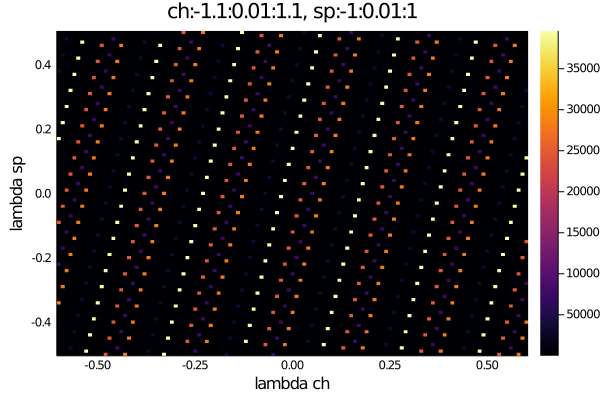

In [217]:
heatmap(λch_range2, λsp_range2, (res2 .- 0).^4, xlabel = "lambda ch", ylabel = "lambda sp", title="ch:-1.1:0.01:1.1, sp:-1:0.01:1")

In [349]:
χ_min_ch    = -minimum(1 ./ real.(χch[ceil(Int64,size(χch,1)/2),:]))
χ_min_sp    = -minimum(1 ./ real.(χsp[ceil(Int64,size(χch,1)/2),:]))
println(χ_min_ch, ", ", χ_min_sp)

-14.473154939042681, 0.09308725343569026


In [375]:
Xint = 0..1.1
fsp(λsp) =  construct_f(0.0, λsp, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
res_sp = IntervalRootFinding.roots(fsp, Xint, Newton, 1e-5)  
println(sort(interval.(res_sp)))
println(maximum(interval.(res_sp)))

Interval{Float64}[[0.0103389, 0.010339], [0.0143941, 0.0144021], [0.0225144, 0.0225147], [0.0236029, 0.023608], [0.0289026, 0.0289106], [0.0387014, 0.0387016], [0.049588, 0.0495966], [0.0626939, 0.062694], [0.0709535, 0.0709617], [0.0833816, 0.0833819], [0.0930821, 0.0930906], [0.0952014, 0.0952076]]
[0.0952014, 0.0952076]


In [377]:
Xint = (χ_min_ch-0.5)..(χ_min_ch+0.5)
χ_min_ch = -minimum(1 ./ real.(χch[floor(Int64,size(χch,1)/2),:]))
fch(λch) =  construct_f(λch, 0.0, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
res_ch = IntervalRootFinding.roots(fch, Xint)  
println(sort(interval.(res_ch)))
println(maximum(interval.(res_ch)))

Interval{Float64}[[227.512, 227.513], [227.514, 227.515]]
[227.514, 227.515]


In [333]:
Xint = -2..2
λch_range = -15:0.1:-14
χ_min_ch    = -minimum(1 ./ real.(χch[floor(Int64,size(χch,1)/2),:]))
res = zeros(length(λch_range))
for (i,λch_i) in enumerate(-15:0.1:-14)
    fsp_int(λsp) =  construct_f(λch_i, λsp, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
    res_sp = IntervalRootFinding.roots(fsp_int, Xint, Newton, 1e-3)
    res_sp_sort = sort(interval.(res_sp))
    println(res_sp_sort)
    res[i] = mid(maximum(interval.(res_sp)))
    println(i)
end

Interval{Float64}[[-0.656976, -0.65666], [-0.645462, -0.644907], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347508], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.30

Interval{Float64}[[-0.617177, -0.617105], [-0.614462, -0.614187], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.348871, -0.347909], [-0.34791, -0.347435], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.3

Interval{Float64}[[-0.615255, -0.614461], [-0.6068, -0.606756], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.348871, -0.347909], [-0.347414, -0.346933], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.30

Interval{Float64}[[-0.668343, -0.667733], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347527], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.305545, -0.304552], [-0.3

Interval{Float64}[[-0.709881, -0.709333], [-0.707951, -0.707624], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347586], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.3

Interval{Float64}[[-0.738249, -0.738186], [-0.42898, -0.427987], [-0.427988, -0.427488], [-0.415326, -0.414349], [-0.41435, -0.413358], [-0.413359, -0.412366], [-0.402512, -0.401519], [-0.40152, -0.400528], [-0.400529, -0.400028], [-0.400029, -0.399521], [-0.399522, -0.398529], [-0.388839, -0.387862], [-0.387863, -0.386916], [-0.386917, -0.385955], [-0.385956, -0.384994], [-0.381105, -0.380113], [-0.380114, -0.379167], [-0.379168, -0.378205], [-0.366491, -0.365499], [-0.364493, -0.363545], [-0.363546, -0.362584], [-0.362585, -0.361623], [-0.352838, -0.351861], [-0.351862, -0.350869], [-0.348871, -0.347909], [-0.34791, -0.347621], [-0.337033, -0.336041], [-0.336042, -0.335541], [-0.330136, -0.329159], [-0.32916, -0.328198], [-0.328199, -0.327221], [-0.322341, -0.321349], [-0.32135, -0.320372], [-0.320373, -0.319381], [-0.319382, -0.318389], [-0.315446, -0.314468], [-0.314469, -0.313477], [-0.313478, -0.312501], [-0.312502, -0.311509], [-0.31151, -0.310518], [-0.307544, -0.306551], [-0.3

In [334]:
res

11-element Array{Float64,1}:
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237
 0.09322727805996237

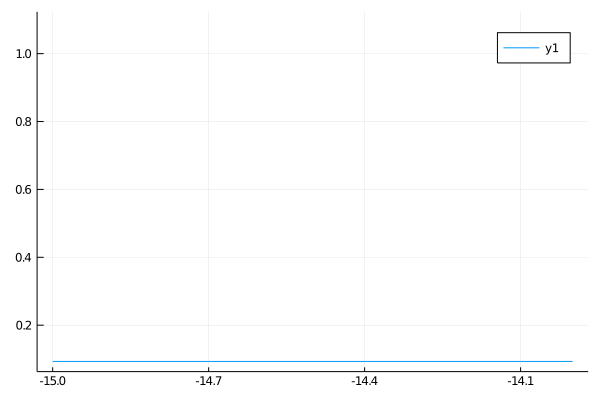

In [335]:
plot(λch_range, res)

In [310]:
Xint = -20..20
function f_full( (λch, λsp) ) 
    r = construct_f(λch, λsp, χch[ωrange,:], χsp[ωrange,:], qMultiplicity, rhs = rhs)
    return SVector(r,r)
end

function test( (λch, λsp) ) 
    r = λch + λsp
    return SVector(r,r)
end
    
res = IntervalRootFinding.roots(f_full, Xint × Xint, Newton, 1e-1)  
#println(sort(interval.(res)))
#println(maximum(interval.(res)))

InterruptException: InterruptException:

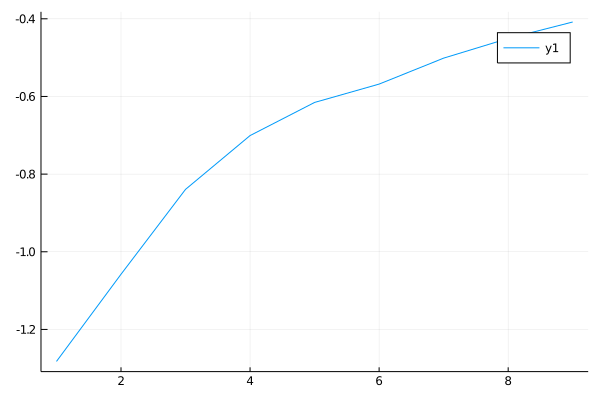

In [62]:
plot(imag.(Σ_ladder[1:9,35]))

In [11]:
χsp[41,:]

56-element Array{Complex{Float64},1}:
  2.3349399499041796 + 9.411477191714448e-25im
   2.409315394519308 + 5.293955920339377e-25im
    2.48974530686027 - 1.1176129165160908e-24im
  2.5770684416759417 + 1.764651973446459e-24im
   2.629817712222572 - 1.7058302409982437e-24im
  2.7296494814613683 + 2.5881562277214734e-24im
   2.839307760241222 + 1.7058302409982437e-24im
   3.032864406680289 - 9.411477191714448e-25im
   3.175418149394974 + 5.88217324482153e-24im
   3.624836145788811 - 1.0587911840678754e-24im
   2.968757662903386 + 5.117490722994731e-24im
  3.1026950584946213 + 8.823259867232295e-25im
  3.2524373908394306 + 8.823259867232295e-25im
                     ⋮
  18.025105479364992 + 2.1286114429697913e-23im
  7.0845317833247465 + 8.823259867232295e-25im
   8.203121219174166 + 7.352716556026913e-24im
   14.16757052558115 + 1.3320181312898354e-22im
    194.547910113105 - 7.812467216842163e-21im
  -20.16362992171506 + 7.717411297205848e-23im
   7.972014245624513 + 2.676388826393796

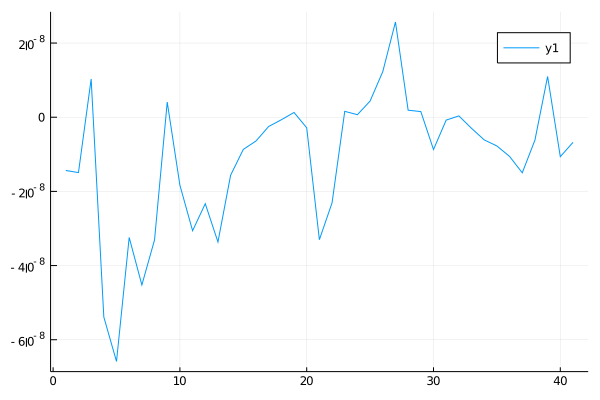

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error


In [50]:
plot(real.(Σ_ladder[:,35]))

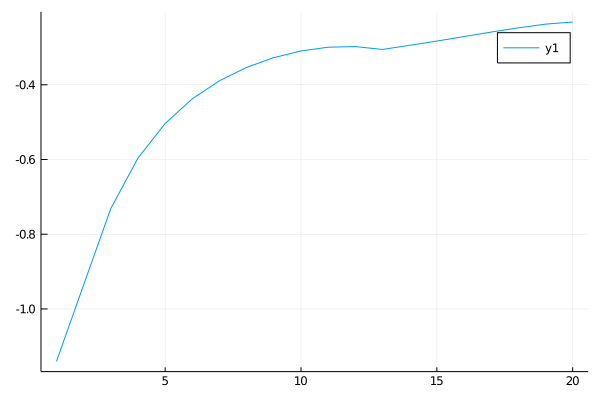

In [55]:
plot(imag.(Σ_ladder[1:20,35]))

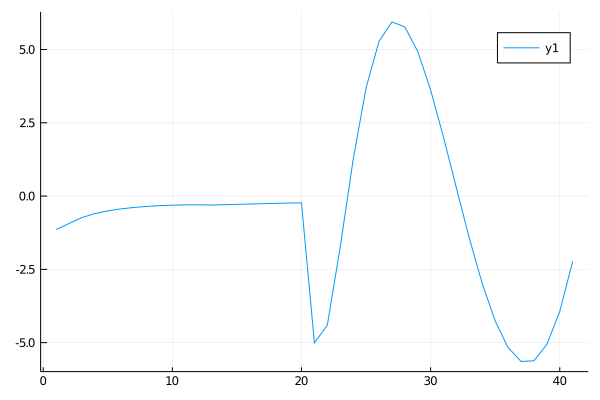

In [56]:
plot(imag.(Σ_ladder[:,35]))

In [67]:
include("src/ladderDGA_Julia.jl")
include("test/loadFortranData.jl")

loadFortranData (generic function with 1 method)

In [71]:
using FortranFiles
bubble_f, χch_f, χsp_f, trilexch_f, trilexsp_f, Σ_f = loadFortranData("/home/julian/Hamburg/ladderDGA3D_FFT");

In [82]:
modelParams, simParams, env, Γch, Γsp, Σ_loc, FUpDo, χLocch, χLocsp, usable_loc_ch, usable_loc_sp = setup_LDGA("config.toml");
bubble, χch, χsp, χsp_λ, usable_sp, usable_ch,trilexch, trilexsp, Σ_ladder= calculate_Σ_ladder("config.toml");

Reading Fortran Input, this can take several minutes.
Done Reading Gamma
Done Reading chi
loading from vars.jld
TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
Reading Inputs...Reading Fortran Input, this can take several minutes.
Done Reading Gamma
Done Reading chi
loading from vars.jld
TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
(81, 82, 82)(81, 82, 82)(81,)(81, 82, 82)
Inputs Read. Starting Computation.
    Found usable intervals for local susceptibility of length 
          sp: 13
          ch: 11 
          χLoc_sp = 0.3836, χLoc_ch = 0.0203
Setting up and calculating k Grid: 
Calculating bubble: 
in bubble: (81,)
gnuomega indices: 122
in bubble: ModelParameters(2.0, 1.0, 15.0, 1.0, 3)
in bubble: SimulationParameters(41, 40, 0, 10, false, false, false, false, "FFT")
  0.701871 seconds (1.46 M allocations: 230.419 MiB, 3.54% gc time)
Calculating χ and γ: 
 71.222047 seconds (1.18 M allocations: 762.011 MiB, 1.05% gc time)
Found usable

In [60]:
ωi = 37;
qi = 56;

In [61]:
UnitM = Matrix{eltype(Γsp)}(I, size(Γsp[1,:,:])...);
bubble_i = bubble[ωi, qi, :];
bubbleD = Diagonal(bubble_i);
A = bubbleD * Γsp[ωi,:,:] + UnitM
χ_full_sp = A\bubbleD;
χsp = sum_freq(χ_full_sp, [1,2], false, 15.0, weights=nothing)[1,1]
tmp = sum_freq(χ_full_sp, [2], false, 1.0, weights=nothing)[:,1];
γres_solve =  tmp ./ (bubble_i * (1.0 + 2.0 * χsp));

In [79]:
println("χ: ", χsp, "\ntmp: ", γres_solve[end])

χ: 0.05059030127327584 + 1.2967212444480171e-9im
tmp: 1.0006926683271116 - 2.792465928549295e-9im


In [80]:
size(trilexsp)

(82,)

In [81]:
size(trilexsp_f)

(81, 56, 82)

In [85]:
all(trilexsp_f[usable_sp,:,:] .≈ trilexsp[usable_sp,:,:])

true

In [75]:
trilexsp_f[ωi, qi, end]

1.0006926683271118 - 2.7924659280366734e-9im

In [64]:
χ_tmp = Matrix(Γsp[ωi, :, :]) + Diagonal(1.0 ./ bubble[ωi, qi, :]);
χ_tmp = inv(χ_tmp)
χsp = sum_freq(χ_tmp, [1,2], false, 15.0, weights=nothing)[1,1]
tmpSum = sum_freq(χ_tmp, [2], false, 1.0, weights=nothing)[:,1]
γres_inv = tmpSum ./ (bubble[ωi, qi, :]  * (1.0 + 2.0 * χsp));

In [65]:
γres_inv[1]

1.001502119239691 - 7.383095390439116e-9im